# Initial Config

We will explore Google's TensorFlow library which is an end-to-end libary for machine learning as well as for building and deploying ML tools and applications. It uses an API called Keras which is largely left to train on its own.

Tensorflow uses Neural Networks for the bulk of its modelling and this is a framework that can be trained to recognize patterns. It is composed of a number of layers; including input and output layers. There are neurons in each layer which is an abstraction represenation of the data. Data classification is then possible by detecting lines, shapes and textures. 

Neural networks are trained by gradient descent. The weights in each layer start with random values and iteratively work over time (epochs) to make the network more accurate. A loss function is also calculate to indicate the accuracy of the network and backpropagation is then used to determine if each weight would should be increased/decreased to minmise the loss.

More information can be found here: https://www.tensorflow.org/about.

We will use a module called heliopy to import sunspot data. More information about this can be found here: https://docs.heliopy.org/en/stable/reference/data/index.html.

In [1]:
# Pip install heliopy which contains the data we need
!pip install heliopy

     |████████████████████████████████| 92kB 5.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for heliopy: filename=HelioPy-0.15.2-cp36-none-any.whl size=82355 sha256=3e12e086a4486c338c071db7e2f1d6daae96527d3be0f76dcc17f2b6cb9099c4
  Stored in directory: /root/.cache/pip/wheels/62/47/f5/02719917ab191717fd9af533af29c1be5cc1949f393831c280
Successfully built heliopy


In [2]:
# Import all the relevant modules
import pandas as pd
import numpy as np
import heliopy.data.sunspot as sunspot

import matplotlib.pyplot as plt
import tensorflow as tf

Creating download directory /root/heliopy/data


In [3]:
class TFConfig:
    """
    The creation of a TensorFlow config to define key info once.
    """
    def __init__(
        self,
        split_ratio: float,
        window_size: int,
        batch_size: int,
        shuffle_buffer: int
        
    ):
        self.split_ratio = split_ratio
        self.window_size = window_size
        self.batch_size = batch_size
        self.shuffle_buffer = shuffle_buffer

In [4]:
tf_config = TFConfig(
    split_ratio=0.8,
    window_size=60,
    batch_size=32,
    shuffle_buffer=1000
)

# Data Importing

In [5]:
# Download the data we need
df_daily, df_monthly, df_yearly = sunspot.daily(), sunspot.monthly(), sunspot.yearly()
df_daily.head()

,Y,M,D,DecD,Daily,Std Dev,No Obs,Def/Prov Ind
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


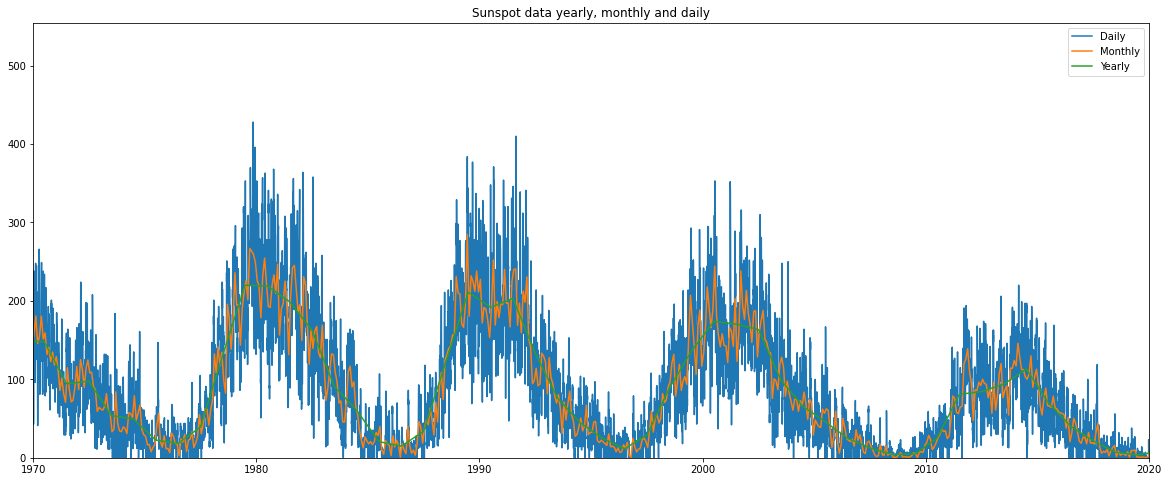

In [6]:
# Visualising the data
fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(20)

ax.plot(df_daily["DecD"], df_daily["Daily"], label="Daily")
ax.plot(df_monthly["DecD"], df_monthly["Monthly"], label="Monthly"),
ax.plot(df_yearly["Y"], df_yearly["Y_Mean"], label="Yearly")

ax.set_xlim(left=1970, right=2020)
ax.set_ylim(bottom=0)
ax.set_title("Sunspot data yearly, monthly and daily")

ax.legend()
plt.show()

# Split into training and validation datasets

In [7]:
# Creating a numpy array of the data and dates
data = df_daily["Daily"].to_numpy()
time_index = np.array(df_daily["DecD"])

In [8]:
# Creating a split index for the creation of training and test data
split_index = int(tf_config.split_ratio * data.shape[0])

In [9]:
# Creation of training and testing data
train_data = data[:split_index]
train_time = time_index[:split_index]

test_data = data[split_index:]
test_time = time_index[split_index:]

# Create a windowed dataset

In [10]:
def tensorflow_data_generator(
    data: np.array,
    tf_config: TFConfig
):
  """
  Generates Tensor tensors data to be inputted into a model.
  """
  ts_data = tf.data.Dataset.from_tensor_slices(data)
  ts_data = ts_data.window(tf_config.window_size + 1, shift=1, drop_remainder=True)
  ts_data = ts_data.flat_map(lambda window: window.batch(tf_config.window_size + 1))

  ts_data = ts_data.shuffle(tf_config.shuffle_buffer).map(
      lambda window: (window[:-1], window[-1])
      )
  
  ts_data = ts_data.batch(tf_config.batch_size).prefetch(1)

  return ts_data

In [11]:
train_dataset = tensorflow_data_generator(data=train_data,tf_config=tf_config)
test_dataset = tensorflow_data_generator(data=test_data, tf_config=tf_config)

# Tensorflow Model

In [12]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [14]:
# Fitting the model
with tf.device('/device:GPU:0'):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(20, input_shape=[tf_config.window_size], activation="relu"), 
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
  model.fit(train_dataset, epochs=200,validation_data = test_dataset)

Epoch 1/200
1853/1853 [==============================] - 12s 6ms/step - loss: 2349.4326 - val_loss: 318.9147
Epoch 2/200
1853/1853 [==============================] - 11s 6ms/step - loss: 1818.0961 - val_loss: 283.2011
Epoch 3/200
1853/1853 [==============================] - 11s 6ms/step - loss: 1755.1007 - val_loss: 253.9473
Epoch 4/200
1853/1853 [==============================] - 11s 6ms/step - loss: 1718.6931 - val_loss: 243.4099
Epoch 5/200
1853/1853 [==============================] - 11s 6ms/step - loss: 1707.7849 - val_loss: 277.1336
Epoch 6/200
1853/1853 [==============================] - 11s 6ms/step - loss: 1698.2388 - val_loss: 235.5486
Epoch 7/200
1853/1853 [==============================] - 11s 6ms/step - loss: 1679.9478 - val_loss: 244.1443
Epoch 8/200
1853/1853 [==============================] - 11s 6ms/step - loss: 1676.0823 - val_loss: 234.5098
Epoch 9/200
1853/1853 [==============================] - 11s 6ms/step - loss: 1661.5133 - val_loss: 284.6508
Epoch 10/200
1853/1

# Model evaluation

In [15]:
# Make a list of the dates to plot
x_range = list(range(split_index,len(data)))

In [16]:
forecast=[]
for time in range(len(data) - tf_config.window_size):
  # For each time date, evaluating the model prediction
  print("\r", f"Evaluating for {time} out of {len(data)}", end="")
  forecast.append(model.predict(data[time:time + tf_config.window_size][np.newaxis]))

forecast = forecast[split_index-tf_config.window_size:]
results = np.array(forecast)[:, 0, 0]

 Evaluating for 74115 out of 74176

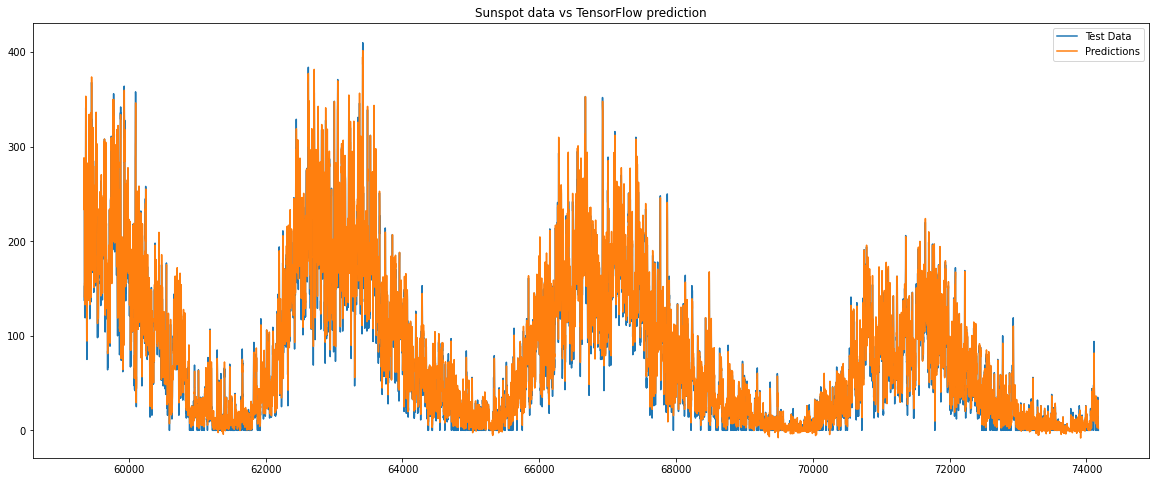

In [17]:
plt.figure(figsize=(20, 8))

plt.plot(x_range, test_data, label = 'Test Data')
plt.plot(x_range, results, label = 'Predictions')
plt.legend()
plt.title("Sunspot data vs TensorFlow prediction")
plt.show()

We can see from the above the model has done a really good at job predicting the daily sunspot data and it follows the overall pattern. What would really be interesting to compare is model diagnostics for other types of time series analysis (Facebook Prophet, ARIMA) to see how accurate they are. TensorFlow models, depending on the amount of data available, can take a long time to compute, learn and build. In this notebook, we enabled a GPU within Google Colab to speed things up but this may not always be possible for all environments.